In [380]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset

In [381]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Debug = False

In [382]:
# 创建一个空列表来存储读取的 DataFrames
dataframes_Cap_111 = []
end = 0
# 使用循环读取文件并分配名称
for i in range(1, 11):
    # 构建文件名
    file_name = f"data/Nature_Cap_train{i:02}"  # 使用 f-string 格式化文件名，确保数字有两位数
    #file_name_EIS = f"data/NMC111EIS{i:02}"
    
    if not os.path.isfile(file_name):
        print(f"Cap文件 {file_name} 不存在，跳过...")
        continue


    # 读取文件并添加到列表
    df = pd.read_csv(file_name, header=None)
    # 将不好的预测的趋势提前阻止
    if i ==1 or i ==4:
        end = 190
    elif i == 6:
        end = 90
    elif i == 7:
        end = 290
        print(len(df))
    else:
        end = len(df)

    label = np.array(df.iloc[:end])
    dataframes_Cap_111.append(label)

326


In [383]:
for i in range(10):
    print(dataframes_Cap_111[i].shape)

(190, 1)
(180, 1)
(201, 1)
(190, 1)
(212, 1)
(90, 1)
(290, 1)
(318, 1)
(299, 1)
(310, 1)


In [384]:
# 将数据合并到X和y并转换成为np.array
y = []
for i in range(0,10):
    tmp = []
    for j in range(dataframes_Cap_111[i].shape[0]):
        y.append(dataframes_Cap_111[i][j])

y = np.array(y)

In [385]:
# 准备数据
def prepare_sequences(seq, num_steps):
    sequences = []
    target = []
    for i in range(len(seq) - num_steps):
        sequences.append(seq[i:i+num_steps])
        target.append(seq[i+num_steps])
    #combined_sequences = np.vstack(sequences)
    #combined_target = np.vstack(target)
    return np.array(sequences), np.array(target)

In [386]:
from sklearn.preprocessing import MinMaxScaler
# 归一化
scaler_111 = MinMaxScaler()
y = scaler_111.fit_transform(y)
print(y.shape)

start = 0
data = {}
train_sequences = []
train_target = []
num_steps = 50
for i in range(10):
    target_name = f'NMC111Cap{i+1:02}'
    n = dataframes_Cap_111[i].shape[0]
    data[target_name] = y[start:start+n]
    if i!=9:
        train_sequences_temp, train_target_temp = prepare_sequences(data[target_name], num_steps)
        train_sequences.append(train_sequences_temp)
        train_target.append(train_target_temp)
    else:
        test_sequences, test_target = prepare_sequences(data[target_name], num_steps)
        print(test_sequences.shape)
    start += n
    
    

(2280, 1)
(260, 50, 1)


In [387]:
# 111 training data
start = 0
for i in range(9):
    if i == 0:
        trainning_data_111 = train_sequences[i][start:].copy()
        trainning_target_111 = train_target[i][start:].copy()
    #将测试集剔除，不参与训练
    elif i!=3 and i!=7:
        trainning_data_111 = np.vstack((trainning_data_111,train_sequences[i][start:]))
        trainning_target_111 = np.vstack((trainning_target_111,train_target[i][start:]))

In [388]:
trainning_data_111.shape

(1112, 50, 1)

In [389]:
trainning_data_111 = torch.tensor(trainning_data_111, dtype=torch.float32)
trainning_target_111 = torch.tensor(trainning_target_111, dtype=torch.float32)
test_data_111 = torch.tensor(test_sequences, dtype=torch.float32)
test_target_111 = torch.tensor(test_target, dtype=torch.float32)

In [390]:
dataset = TensorDataset(trainning_data_111, trainning_target_111)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [391]:
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.num_layers = num_layers
        self.hidden_dim = hidden_size

    def forward(self, x):
        h0 = torch.randn((self.num_layers, x.shape[0], self.hidden_dim)).to(device) # 初始化隐藏状态
        c0 = torch.randn((self.num_layers, x.shape[0], self.hidden_dim)).to(device) # 初始化细胞状态
        
        out, _ = self.lstm(x,(h0,c0))
        out = self.fc(out[:, -1, :])
        return out

In [392]:
# 初始化模型、损失函数和优化器
input_size = 1 # 特征数量
hidden_size = 16
num_layers = 10
batch_size = 64
epochs = 200
n_splits = 5

In [393]:
from sklearn.model_selection import KFold  

In [394]:
import gc
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()
gc_collect()

In [395]:
kf = KFold(n_splits=n_splits, shuffle=True)

model_number = 0
for train_idx, val_idx in kf.split(trainning_data_111):  
    train_X, val_X = trainning_data_111[train_idx], trainning_data_111[val_idx]  
    train_y, val_y = trainning_target_111[train_idx], trainning_target_111[val_idx]  
    train_dataset = TensorDataset(train_X, train_y)  
    val_dataset = TensorDataset(val_X, val_y)  
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  
    model = LSTMModel(input_size, hidden_size, num_layers)
    model = model.to(device)
    criterion = nn.MSELoss()   
    optimizer = optim.Adam(model.parameters(), lr=0.0001,betas=(0.5,0.999))  
     
    for epoch in range(epochs):
        model.train() 
        for i, (inputs, labels) in enumerate(train_loader):  
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)  
                val_loss = criterion(outputs, labels)    
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()}') 
    torch.save(model.state_dict(), f"model_weights/predict_curve/model_50step_test_{model_number}.pth")
    model_number += 1
    #model.reset_states()  # 重置模型状态，以便进行下一次交叉验证  

Epoch [1/200], Loss: 0.21097275614738464, Validation Loss: 0.3530220687389374
Epoch [2/200], Loss: 0.2315986007452011, Validation Loss: 0.3336365520954132
Epoch [3/200], Loss: 0.20330394804477692, Validation Loss: 0.31426212191581726
Epoch [4/200], Loss: 0.17230324447155, Validation Loss: 0.294508695602417
Epoch [5/200], Loss: 0.17757971584796906, Validation Loss: 0.27395719289779663
Epoch [6/200], Loss: 0.1759849190711975, Validation Loss: 0.2522861063480377
Epoch [7/200], Loss: 0.12419827282428741, Validation Loss: 0.22906909883022308
Epoch [8/200], Loss: 0.1418353170156479, Validation Loss: 0.2040792554616928
Epoch [9/200], Loss: 0.11019986122846603, Validation Loss: 0.17663103342056274
Epoch [10/200], Loss: 0.07867913693189621, Validation Loss: 0.14604058861732483
Epoch [11/200], Loss: 0.05252312868833542, Validation Loss: 0.11375360190868378
Epoch [12/200], Loss: 0.05282336845993996, Validation Loss: 0.08409623056650162
Epoch [13/200], Loss: 0.03232262283563614, Validation Loss: 0

Epoch [103/200], Loss: 0.00122024433221668, Validation Loss: 0.0009160065092146397
Epoch [104/200], Loss: 0.0007745951879769564, Validation Loss: 0.0006043508765287697
Epoch [105/200], Loss: 0.0010047079995274544, Validation Loss: 0.000998806906864047
Epoch [106/200], Loss: 0.0013546645641326904, Validation Loss: 0.0002844073751475662
Epoch [107/200], Loss: 0.0012284640688449144, Validation Loss: 0.00026922437245957553
Epoch [108/200], Loss: 0.0014727121451869607, Validation Loss: 0.00025540468050166965
Epoch [109/200], Loss: 0.000630637223366648, Validation Loss: 0.0006018803105689585
Epoch [110/200], Loss: 0.0007254487136378884, Validation Loss: 0.00037070916732773185
Epoch [111/200], Loss: 0.00081348029198125, Validation Loss: 0.0002485885634087026
Epoch [112/200], Loss: 0.0011779770720750093, Validation Loss: 0.0005458375089801848
Epoch [113/200], Loss: 0.0007077641785144806, Validation Loss: 0.0008253358537331223
Epoch [114/200], Loss: 0.0009461921872571111, Validation Loss: 0.000

Epoch [2/200], Loss: 0.3147384226322174, Validation Loss: 0.5300312042236328
Epoch [3/200], Loss: 0.32398512959480286, Validation Loss: 0.5085502862930298
Epoch [4/200], Loss: 0.25421756505966187, Validation Loss: 0.48588836193084717
Epoch [5/200], Loss: 0.27555662393569946, Validation Loss: 0.4614907503128052
Epoch [6/200], Loss: 0.25975301861763, Validation Loss: 0.4343993365764618
Epoch [7/200], Loss: 0.2303442507982254, Validation Loss: 0.40358155965805054
Epoch [8/200], Loss: 0.21653299033641815, Validation Loss: 0.36781108379364014
Epoch [9/200], Loss: 0.19956395030021667, Validation Loss: 0.32531023025512695
Epoch [10/200], Loss: 0.1633746176958084, Validation Loss: 0.2748323082923889
Epoch [11/200], Loss: 0.08497659862041473, Validation Loss: 0.21713097393512726
Epoch [12/200], Loss: 0.08231564611196518, Validation Loss: 0.15814760327339172
Epoch [13/200], Loss: 0.04073343425989151, Validation Loss: 0.10605122148990631
Epoch [14/200], Loss: 0.0341486819088459, Validation Loss: 

Epoch [104/200], Loss: 0.0006448753993026912, Validation Loss: 0.0002575972175691277
Epoch [105/200], Loss: 0.0007661647396162152, Validation Loss: 0.0002850530145224184
Epoch [106/200], Loss: 0.0009047701605595648, Validation Loss: 0.00022248820459935814
Epoch [107/200], Loss: 0.0006918224389664829, Validation Loss: 0.0003822384460363537
Epoch [108/200], Loss: 0.0006070920499041677, Validation Loss: 0.00035753316478803754
Epoch [109/200], Loss: 0.00097519566770643, Validation Loss: 0.0008431496098637581
Epoch [110/200], Loss: 0.0008309220429509878, Validation Loss: 0.00042423492413945496
Epoch [111/200], Loss: 0.0007229588809423149, Validation Loss: 0.00027691383729688823
Epoch [112/200], Loss: 0.0006620398489758372, Validation Loss: 0.00028379756258800626
Epoch [113/200], Loss: 0.000890746305231005, Validation Loss: 0.00036112184170633554
Epoch [114/200], Loss: 0.000892610230948776, Validation Loss: 0.0007078932831063867
Epoch [115/200], Loss: 0.0009134029969573021, Validation Loss: 

Epoch [3/200], Loss: 0.33790111541748047, Validation Loss: 0.5675464868545532
Epoch [4/200], Loss: 0.3383868336677551, Validation Loss: 0.5504249334335327
Epoch [5/200], Loss: 0.336320161819458, Validation Loss: 0.5321661233901978
Epoch [6/200], Loss: 0.25042617321014404, Validation Loss: 0.5117889046669006
Epoch [7/200], Loss: 0.28498971462249756, Validation Loss: 0.4877913296222687
Epoch [8/200], Loss: 0.25002649426460266, Validation Loss: 0.4571256637573242
Epoch [9/200], Loss: 0.20901483297348022, Validation Loss: 0.4167191982269287
Epoch [10/200], Loss: 0.16104428470134735, Validation Loss: 0.36463358998298645
Epoch [11/200], Loss: 0.12472879141569138, Validation Loss: 0.30299466848373413
Epoch [12/200], Loss: 0.10683876276016235, Validation Loss: 0.23641233146190643
Epoch [13/200], Loss: 0.08552026003599167, Validation Loss: 0.17046624422073364
Epoch [14/200], Loss: 0.04131627827882767, Validation Loss: 0.11354116350412369
Epoch [15/200], Loss: 0.030373401939868927, Validation Lo

Epoch [105/200], Loss: 0.0016475517768412828, Validation Loss: 0.0013302076840773225
Epoch [106/200], Loss: 0.001302166492678225, Validation Loss: 0.001118115964345634
Epoch [107/200], Loss: 0.000632367271464318, Validation Loss: 0.0004394448478706181
Epoch [108/200], Loss: 0.0008383356034755707, Validation Loss: 0.0007559076184406877
Epoch [109/200], Loss: 0.000609301496297121, Validation Loss: 0.00048565154429525137
Epoch [110/200], Loss: 0.0006888980860821903, Validation Loss: 0.000737457477953285
Epoch [111/200], Loss: 0.0008917576633393764, Validation Loss: 0.0004853693535551429
Epoch [112/200], Loss: 0.0005607101484201849, Validation Loss: 0.0003521475300658494
Epoch [113/200], Loss: 0.0008127815090119839, Validation Loss: 0.0004882737121079117
Epoch [114/200], Loss: 0.0006238567875698209, Validation Loss: 0.0006022941088303924
Epoch [115/200], Loss: 0.0007787670474499464, Validation Loss: 0.0004489760030992329
Epoch [116/200], Loss: 0.0007830756367184222, Validation Loss: 0.0004

Epoch [4/200], Loss: 0.14112843573093414, Validation Loss: 0.32155734300613403
Epoch [5/200], Loss: 0.15872955322265625, Validation Loss: 0.30394959449768066
Epoch [6/200], Loss: 0.16275455057621002, Validation Loss: 0.28550586104393005
Epoch [7/200], Loss: 0.1621047556400299, Validation Loss: 0.2650710940361023
Epoch [8/200], Loss: 0.13930591940879822, Validation Loss: 0.24068984389305115
Epoch [9/200], Loss: 0.08937424421310425, Validation Loss: 0.20909446477890015
Epoch [10/200], Loss: 0.08897939324378967, Validation Loss: 0.16727662086486816
Epoch [11/200], Loss: 0.05694102868437767, Validation Loss: 0.11724259704351425
Epoch [12/200], Loss: 0.04756445810198784, Validation Loss: 0.07388024032115936
Epoch [13/200], Loss: 0.03604663908481598, Validation Loss: 0.04995972663164139
Epoch [14/200], Loss: 0.03584449738264084, Validation Loss: 0.040377628058195114
Epoch [15/200], Loss: 0.02565334364771843, Validation Loss: 0.03740692511200905
Epoch [16/200], Loss: 0.03619733080267906, Vali

Epoch [106/200], Loss: 0.0014465298736467957, Validation Loss: 0.0012944854097440839
Epoch [107/200], Loss: 0.001018461654894054, Validation Loss: 0.0005397193017415702
Epoch [108/200], Loss: 0.0008614013204351068, Validation Loss: 0.0007850571419112384
Epoch [109/200], Loss: 0.0013554018223658204, Validation Loss: 0.0014823434175923467
Epoch [110/200], Loss: 0.0005881687393411994, Validation Loss: 0.0004654773510992527
Epoch [111/200], Loss: 0.0007326907361857593, Validation Loss: 0.0003696667845360935
Epoch [112/200], Loss: 0.0012519736774265766, Validation Loss: 0.00044887737021781504
Epoch [113/200], Loss: 0.0007895019371062517, Validation Loss: 0.00050314114196226
Epoch [114/200], Loss: 0.0006325635476969182, Validation Loss: 0.0007244849111884832
Epoch [115/200], Loss: 0.0007544656982645392, Validation Loss: 0.0005241160979494452
Epoch [116/200], Loss: 0.0008664025226607919, Validation Loss: 0.0007170266471803188
Epoch [117/200], Loss: 0.0005237788427621126, Validation Loss: 0.00

Epoch [5/200], Loss: 0.30541449785232544, Validation Loss: 0.48750752210617065
Epoch [6/200], Loss: 0.2672666609287262, Validation Loss: 0.4590837061405182
Epoch [7/200], Loss: 0.28782588243484497, Validation Loss: 0.4236602485179901
Epoch [8/200], Loss: 0.2110331803560257, Validation Loss: 0.3764561414718628
Epoch [9/200], Loss: 0.20658409595489502, Validation Loss: 0.3108079135417938
Epoch [10/200], Loss: 0.11853849142789841, Validation Loss: 0.22457747161388397
Epoch [11/200], Loss: 0.06140344589948654, Validation Loss: 0.14210885763168335
Epoch [12/200], Loss: 0.051961883902549744, Validation Loss: 0.08849871903657913
Epoch [13/200], Loss: 0.03848728910088539, Validation Loss: 0.05948220565915108
Epoch [14/200], Loss: 0.034896980971097946, Validation Loss: 0.044611990451812744
Epoch [15/200], Loss: 0.03131648153066635, Validation Loss: 0.037694402039051056
Epoch [16/200], Loss: 0.033447060734033585, Validation Loss: 0.03499400615692139
Epoch [17/200], Loss: 0.028237132355570793, Va

Epoch [107/200], Loss: 0.0011102976277470589, Validation Loss: 0.0013935142196714878
Epoch [108/200], Loss: 0.0008454567869193852, Validation Loss: 0.0006571108242496848
Epoch [109/200], Loss: 0.0005733763100579381, Validation Loss: 0.000686174666043371
Epoch [110/200], Loss: 0.0009009832283481956, Validation Loss: 0.0005248861853033304
Epoch [111/200], Loss: 0.0014443767722696066, Validation Loss: 0.002055781427770853
Epoch [112/200], Loss: 0.0009781282860785723, Validation Loss: 0.0005806844565086067
Epoch [113/200], Loss: 0.0008372196462005377, Validation Loss: 0.00044481080840341747
Epoch [114/200], Loss: 0.0009190751588903368, Validation Loss: 0.0008560639107599854
Epoch [115/200], Loss: 0.0008574938401579857, Validation Loss: 0.0007290702196769416
Epoch [116/200], Loss: 0.0009069368825294077, Validation Loss: 0.0014224461046978831
Epoch [117/200], Loss: 0.000946834625210613, Validation Loss: 0.0012340780813246965
Epoch [118/200], Loss: 0.0011476989602670074, Validation Loss: 0.00

In [396]:
def predict_cap(test_data, model1, model2, model3, model4, model5):
    models = [model1, model2, model3, model4, model5]
    with torch.no_grad():
        test_sequence = test_data[0].unsqueeze(0).float()  # 使用测试集中的第一个窗口作为起始点

        predictions = []
        upper = []
        lower = []

    for _ in range(test_data.shape[0]):
        prediction = []
        for model in models:
            model.eval()
            temp = model(test_sequence)
            prediction.append(temp)
        mean = sum(prediction) / len(prediction)
        mean_out = mean
        mean_out = mean_out.cpu()
        mean_out = mean_out.detach().numpy()
        up = max(prediction)
        up = up.cpu()
        up = up.detach().numpy()
        lo = min(prediction)
        lo = lo.cpu()
        lo = lo.detach().numpy()
        predictions.append(mean_out)
        upper.append(up)
        lower.append(lo)
        #mean = torch.tensor(mean, dtype=torch.float32)

        # 将预测值添加到输入序列的末尾，形成新的滑动窗口
        new_input = torch.cat((test_sequence[:, 1:, :], mean.unsqueeze(2)), dim=1)
        test_sequence = new_input
    return predictions, upper, lower

In [397]:
from sklearn.metrics import r2_score
#model_111.load_state_dict(torch.load("model_weights/Cap_predict_LSTM_50step.pth"))

In [398]:
model0 = LSTMModel(input_size, hidden_size, num_layers)
model0.load_state_dict(torch.load(f"model_weights/predict_curve/model_50step_test_0.pth"))
model0 = model0.to(device)
model1 = LSTMModel(input_size, hidden_size, num_layers)
model1.load_state_dict(torch.load(f"model_weights/predict_curve/model_50step_test_1.pth"))
model1 = model1.to(device)
model2 = LSTMModel(input_size, hidden_size, num_layers)
model2.load_state_dict(torch.load(f"model_weights/predict_curve/model_50step_test_2.pth"))
model2 = model2.to(device)
model3 = LSTMModel(input_size, hidden_size, num_layers)
model3.load_state_dict(torch.load(f"model_weights/predict_curve/model_50step_test_3.pth"))
model3 = model3.to(device)
model4 = LSTMModel(input_size, hidden_size, num_layers)
model4.load_state_dict(torch.load(f"model_weights/predict_curve/model_50step_test_4.pth"))
model4 = model4.to(device)
test_data_111, test_target_111 = test_data_111.to(device), test_target_111.to(device)
predictions = predict_cap(test_data_111,model0, model1, model2, model3, model4)

In [399]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

train RMSE:  1.0923277478020983 test RMSE:  0.0
train R2:  -1.778024463851456 test RMSE:  0.0


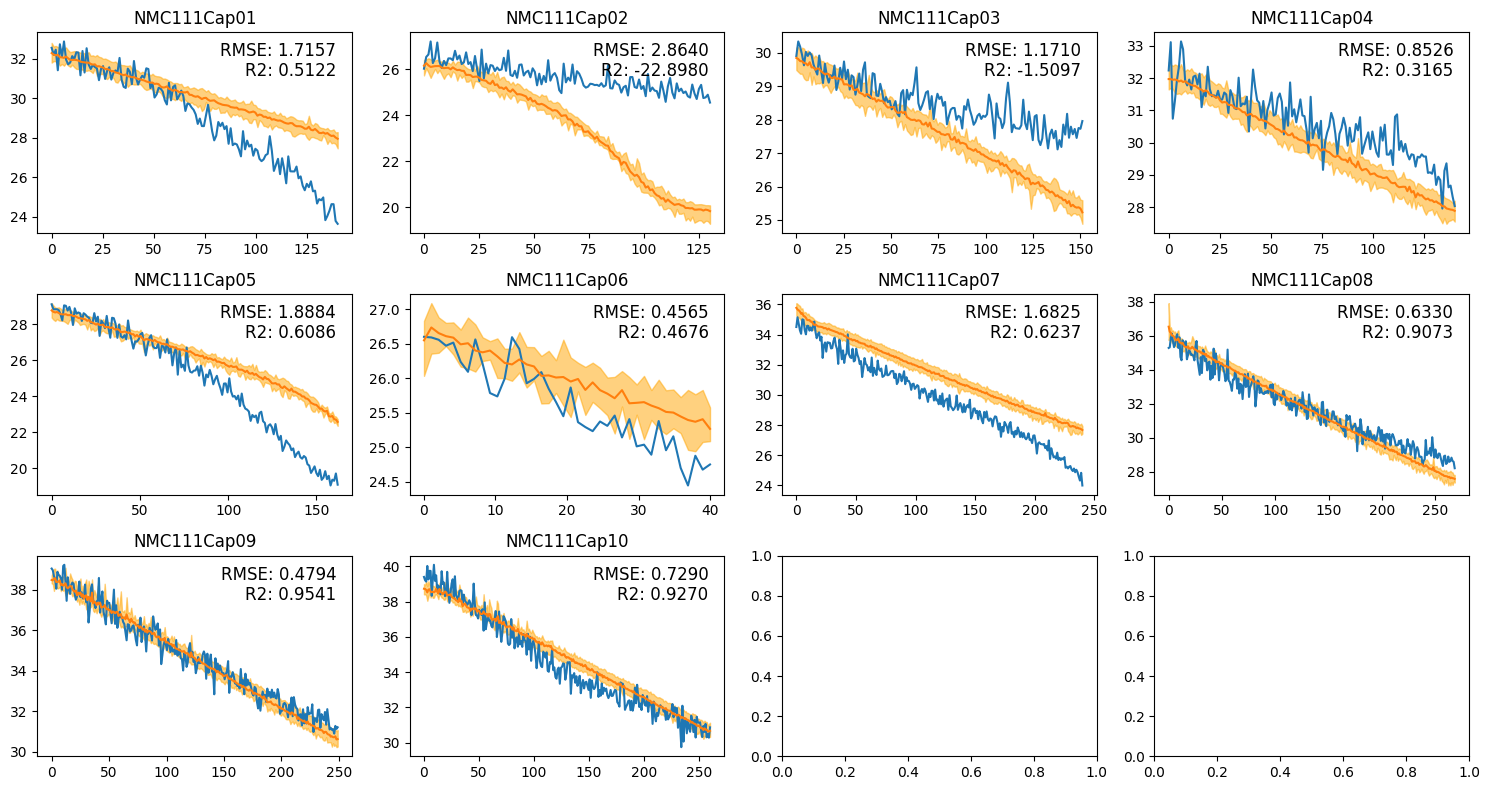

In [408]:
# 创建画布  
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 8))  
ID = 0
flag = 0
title_name = 1
mean_RMSE_train = 0
mean_RMSE_test = 0
mean_R2_train = 0
mean_R2_test = 0
# 在每个小区域中绘制图像  
for i in range(3):  
    for j in range(4):
        if ID == 9:
            x = test_data_111
            true_temp = test_target
#         elif ID == 4:
#             x = torch.tensor(np.expand_dims(data[f"NMC111Cap{ID+1:02}"][:50],axis=0), dtype=torch.float32)
        else:
            x = torch.tensor(train_sequences[ID], dtype=torch.float32)
            true_temp = train_target[ID]
        #x = torch.tensor(data[f"NMC111Cap{ID:02}"], dtype=torch.float32)
        x = x.to(device)
        out,out_upper,out_lower = predict_cap(x,model0, model1, model2, model3, model4)
        out = np.array(out)
        out_upper = np.array(out_upper)
        out_lower = np.array(out_lower)
        out = out.flatten()
        out_upper = out_upper.flatten()
        out_lower = out_lower.flatten()
        out = np.expand_dims(out, axis=1)
        out = scaler_111.inverse_transform(out)
        out_upper = np.expand_dims(out_upper, axis=1)
        out_upper = scaler_111.inverse_transform(out_upper)
        out_lower = np.expand_dims(out_lower, axis=1)
        out_lower = scaler_111.inverse_transform(out_lower)
        true = scaler_111.inverse_transform(true_temp)
        MSE = mean_squared_error(out, true) 
        R2_result = r2_score(true, out) 
        RMSE_result = math.sqrt(MSE)
        if ID!= 5 and ID !=12 and ID !=11:
            mean_RMSE_train += RMSE_result
            mean_R2_train += R2_result
        if ID ==12 or ID ==11:
            mean_RMSE_test += RMSE_result
            mean_R2_test += R2_result
        RMSE_str = "{:.4f}".format(RMSE_result)
        R2_str = "{:.4f}".format(R2_result)
        x = np.linspace(0,x.shape[0],x.shape[0])
        axs[i, j].plot(x, true)
        axs[i, j].plot(x, out)
        out_upper = out_upper.flatten()
        out_lower = out_lower.flatten()
        axs[i, j].fill_between(x, out_upper, out_lower, color='orange', alpha=0.5)
        axs[i, j].set_title(f"NMC111Cap{title_name:02}")
        axs[i, j].text(0.95, 0.95, "RMSE: "+ RMSE_str, ha='right', va='top', fontsize=12, transform=axs[i, j].transAxes)
        axs[i, j].text(0.95, 0.85, "R2: "+ R2_str, ha='right', va='top', fontsize=12, transform=axs[i, j].transAxes)
        with open(f"data/Nature_Cap_predict{title_name:02}", 'w') as file:
            for item in range(out[start:].shape[0]):
                out_number = round(float(out[start:][item].flatten()), 4)
                file.write(str(out_number) + '\t'+str(out_upper[start:][item])+ '\t'+str(out_lower[start:][item])+ '\n')
        # 关闭文件
        file.close()
        ID += 1
        title_name += 1
        if ID == 10:
            flag=1
            break
    if flag==1:
        break
        


# 调整子图之间的距离  
plt.tight_layout()
plt.savefig('figure_results/Cap_predict_111_LSTM.png')
print("train RMSE: ", mean_RMSE_train/11, "test RMSE: ", mean_RMSE_test/2)
print("train R2: ", mean_R2_train/11, "test RMSE: ", mean_R2_test/2)
  
# 显示图像  
plt.show()